In [1]:
import pandas as pd
import pandas.api.types as api
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import NearMiss
from sklearn.metrics import recall_score,precision_score,accuracy_score,f1_score
import missingno as msno
from sklearn.preprocessing import MinMaxScaler,OrdinalEncoder,OneHotEncoder
import scipy.stats as st
from sklearn.model_selection import KFold,GridSearchCV,train_test_split
from sklearn.svm import SVC


In [2]:

def custom_combiner(feature, category):
    return str(feature) + "_" + type(category).__name__ + "_" + str(category)

In [3]:
data=pd.read_csv("C:/Users/ASUS/Desktop/MetehanHocaDDO/bank-full.csv",sep=";",na_values=["unknown"])

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        44923 non-null  object
 2   marital    45211 non-null  object
 3   education  43354 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    32191 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   8252 non-null   object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [6]:
"""np.random.seed(0)
chosen_idx = np.random.choice(data.index, replace=False, size=3000)
data=data.loc[chosen_idx,:]
data=data.reset_index(drop=True)
data.shape"""

'np.random.seed(0)\nchosen_idx = np.random.choice(data.index, replace=False, size=3000)\ndata=data.loc[chosen_idx,:]\ndata=data.reset_index(drop=True)\ndata.shape'

<Axes: >

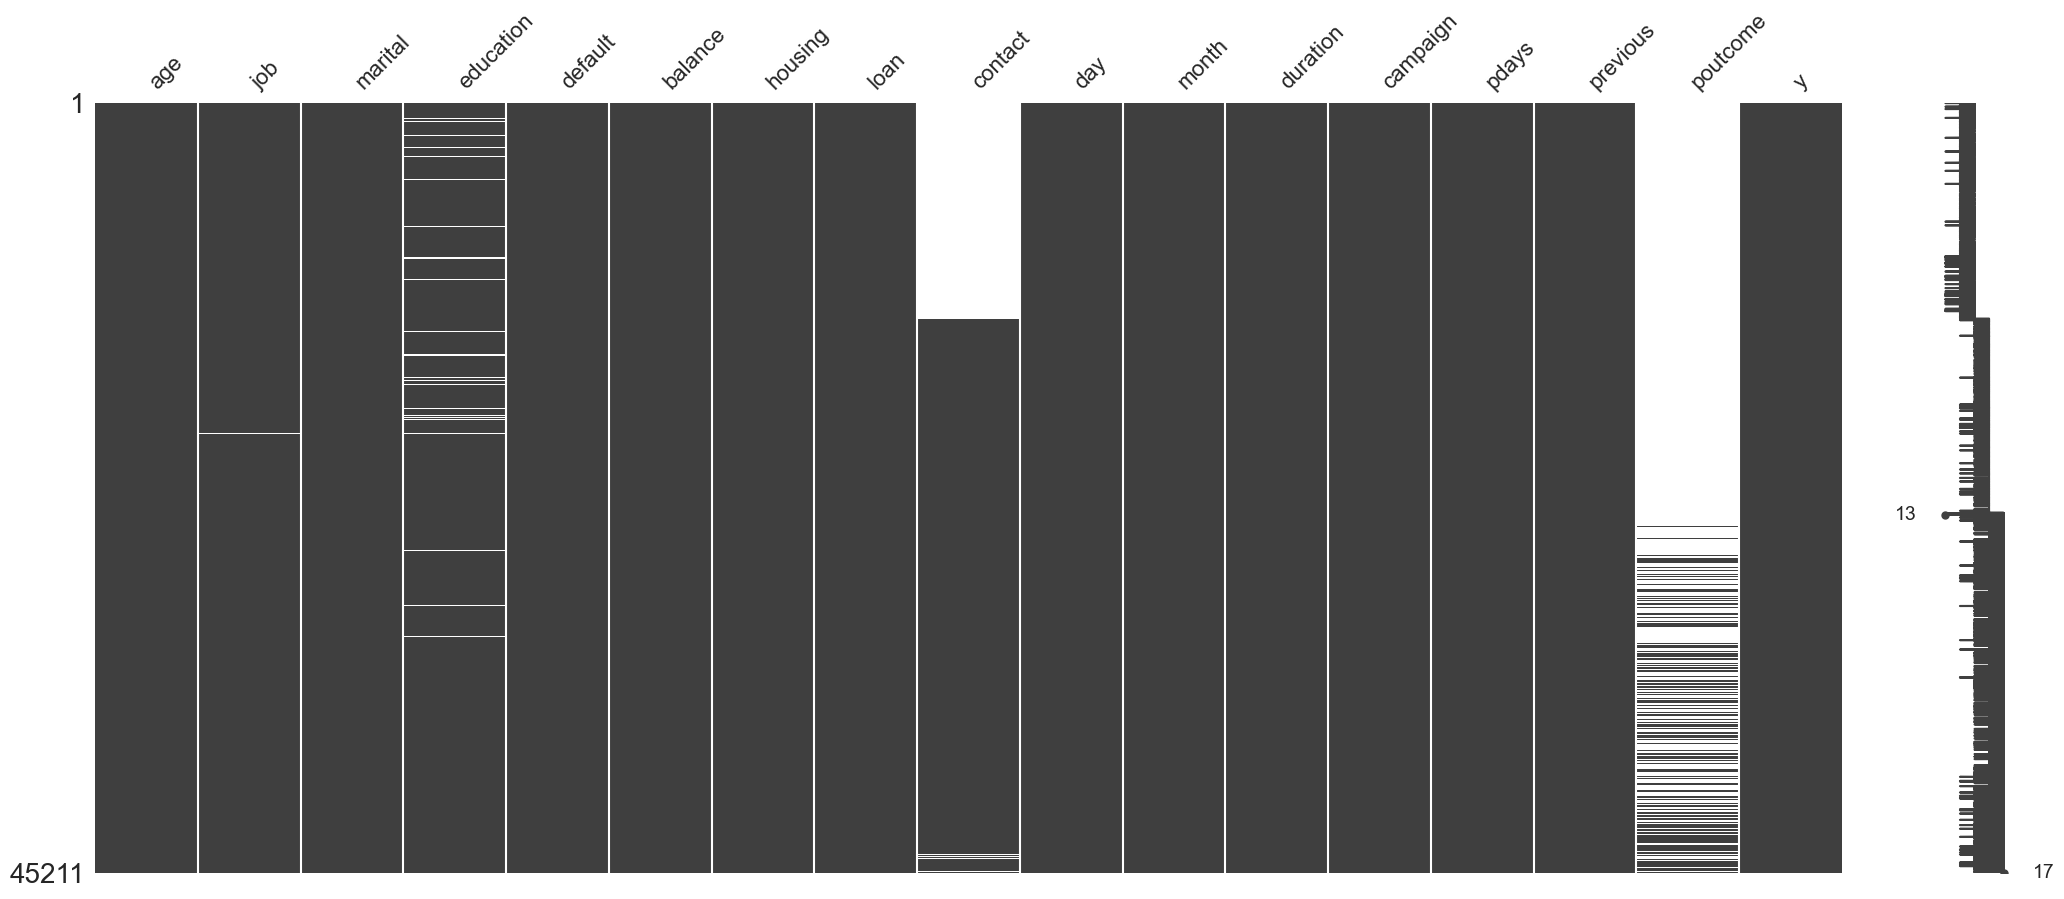

In [7]:
msno.matrix(data)

<Axes: >

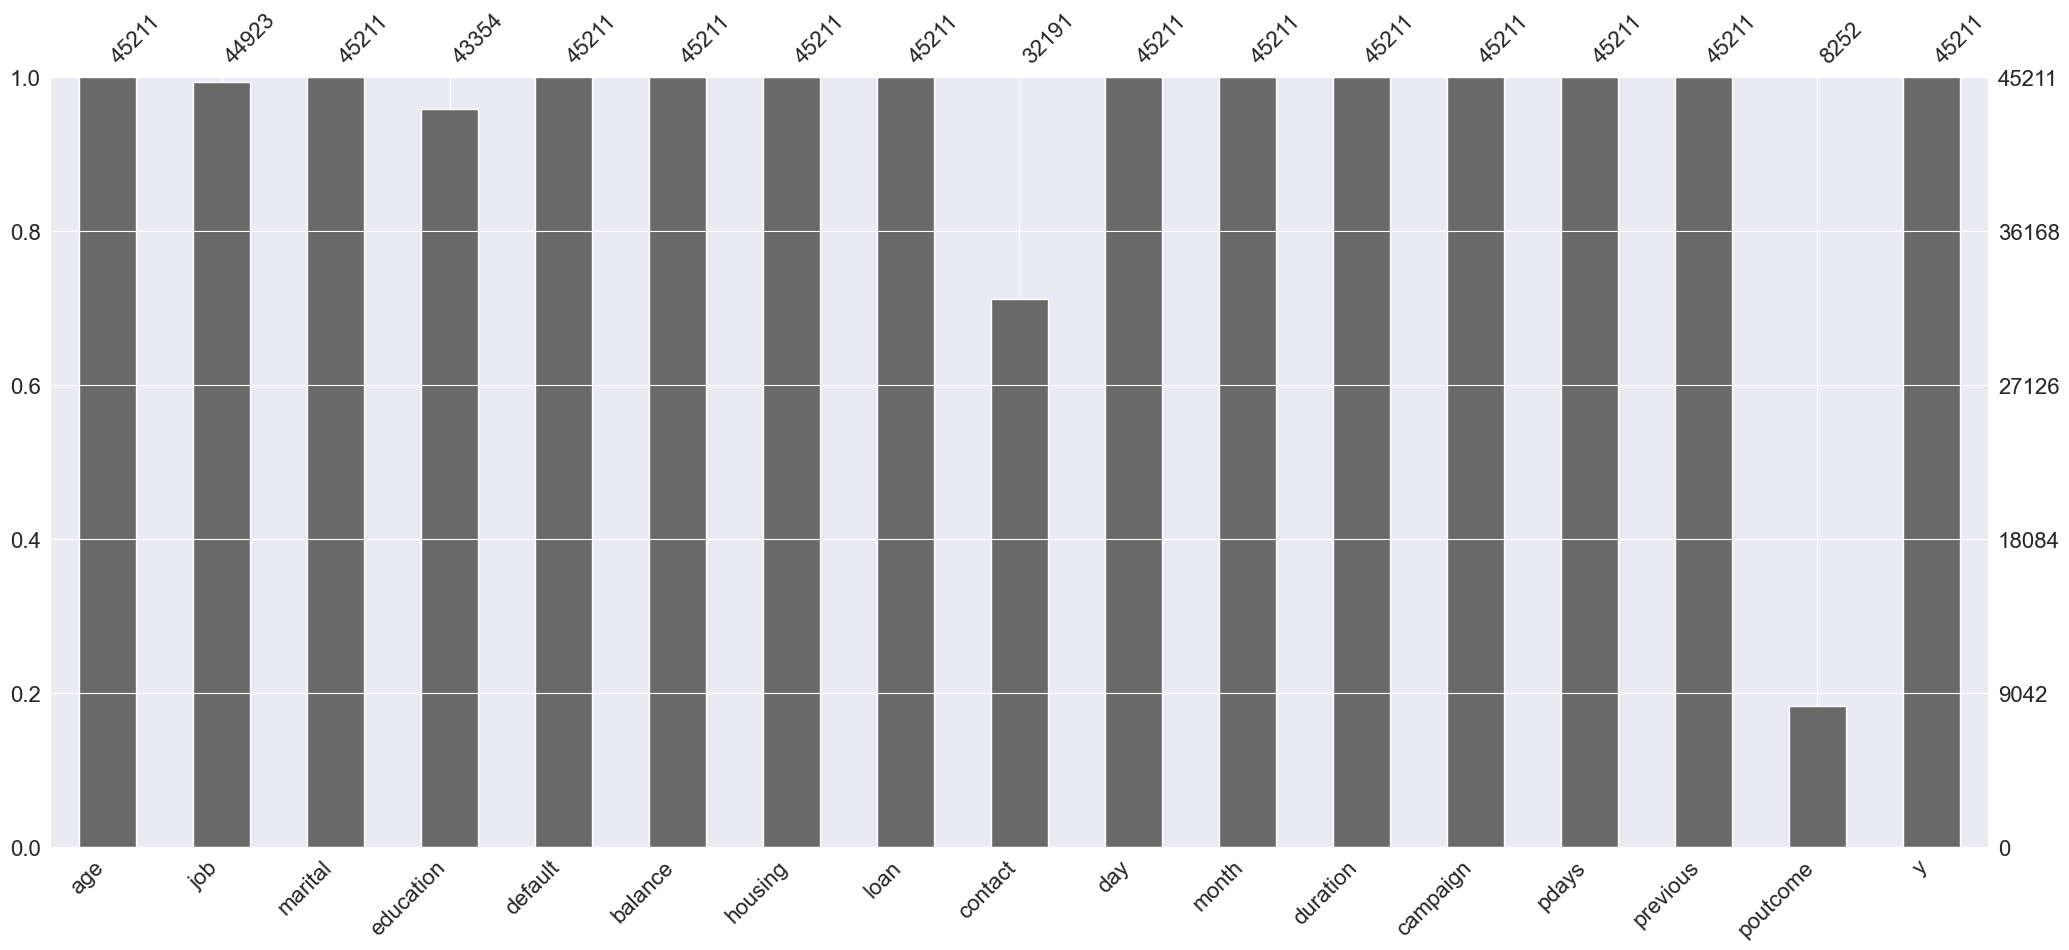

In [8]:
msno.bar(data)

In [9]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
data[data.select_dtypes(include=np.number).columns.tolist()]=imputer.fit_transform(data.select_dtypes(include=np.number))

In [10]:
from sklearn.impute import SimpleImputer

imp_most_frequent = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data[data.select_dtypes(include=np.object_).columns.tolist()]=imp_most_frequent.fit_transform(data.select_dtypes(include=np.object_))

<Axes: >

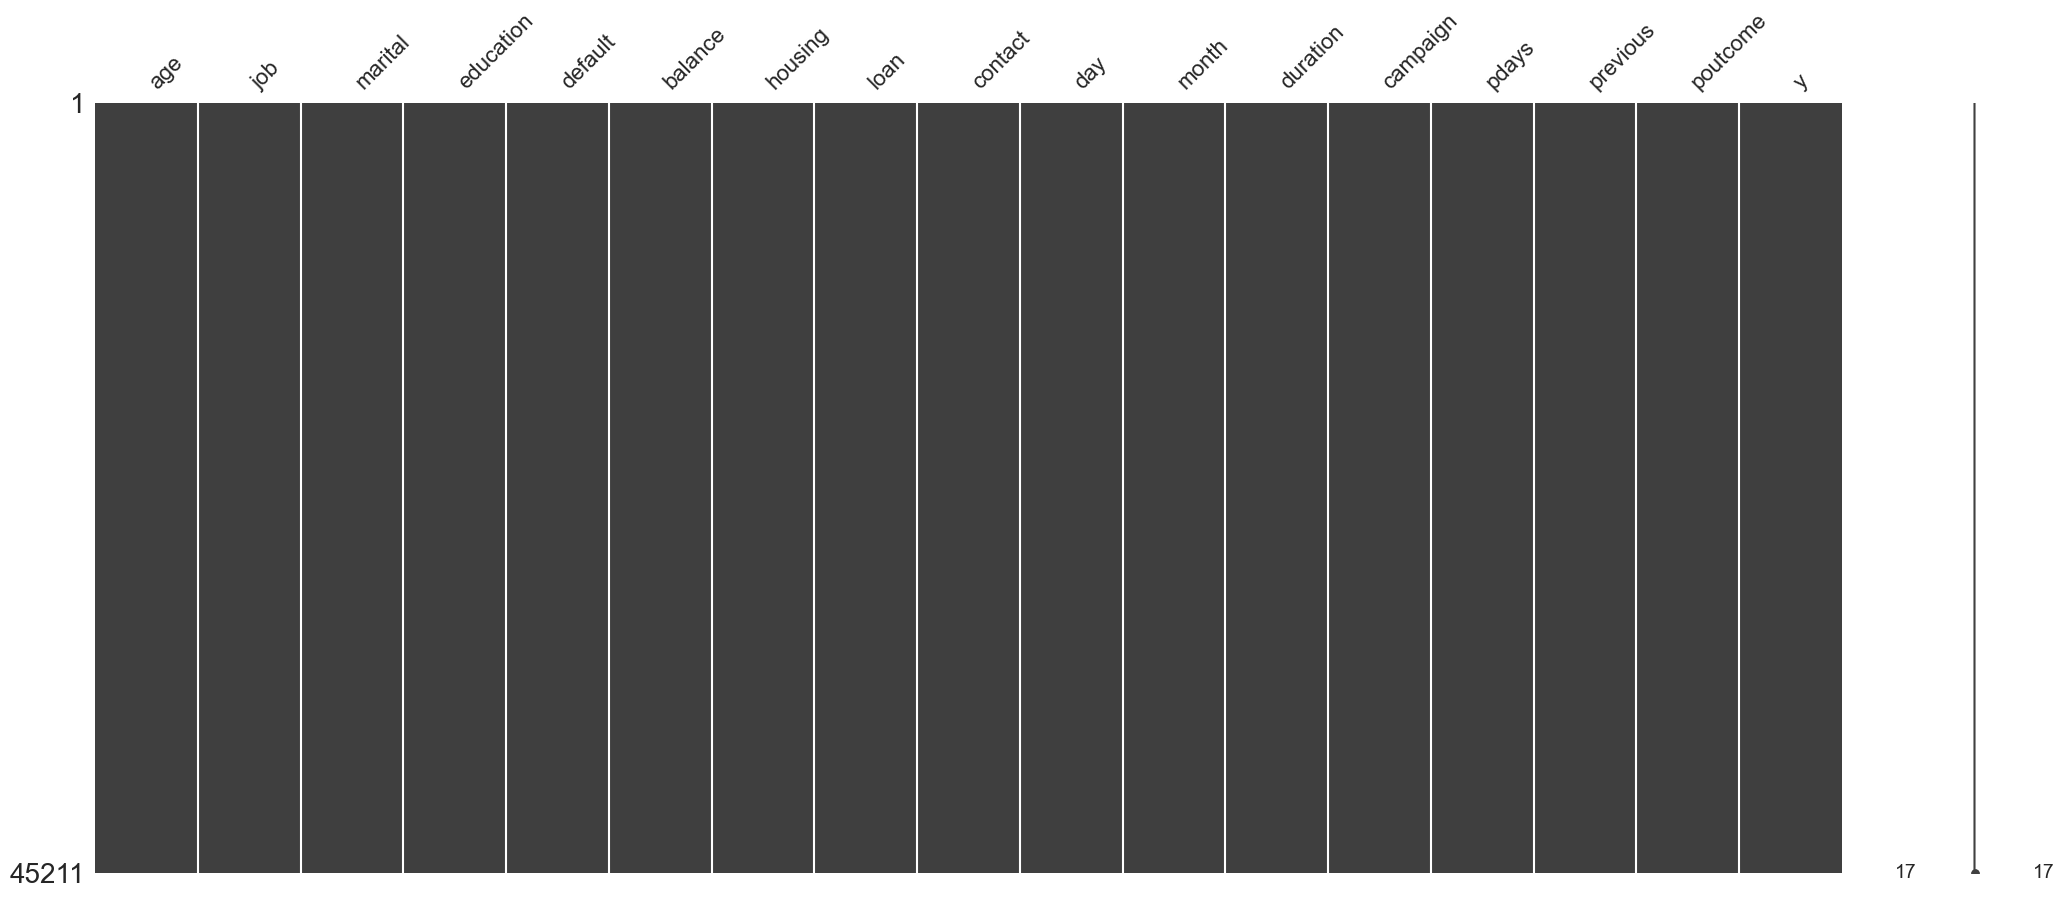

In [11]:
msno.matrix(data)

<Axes: >

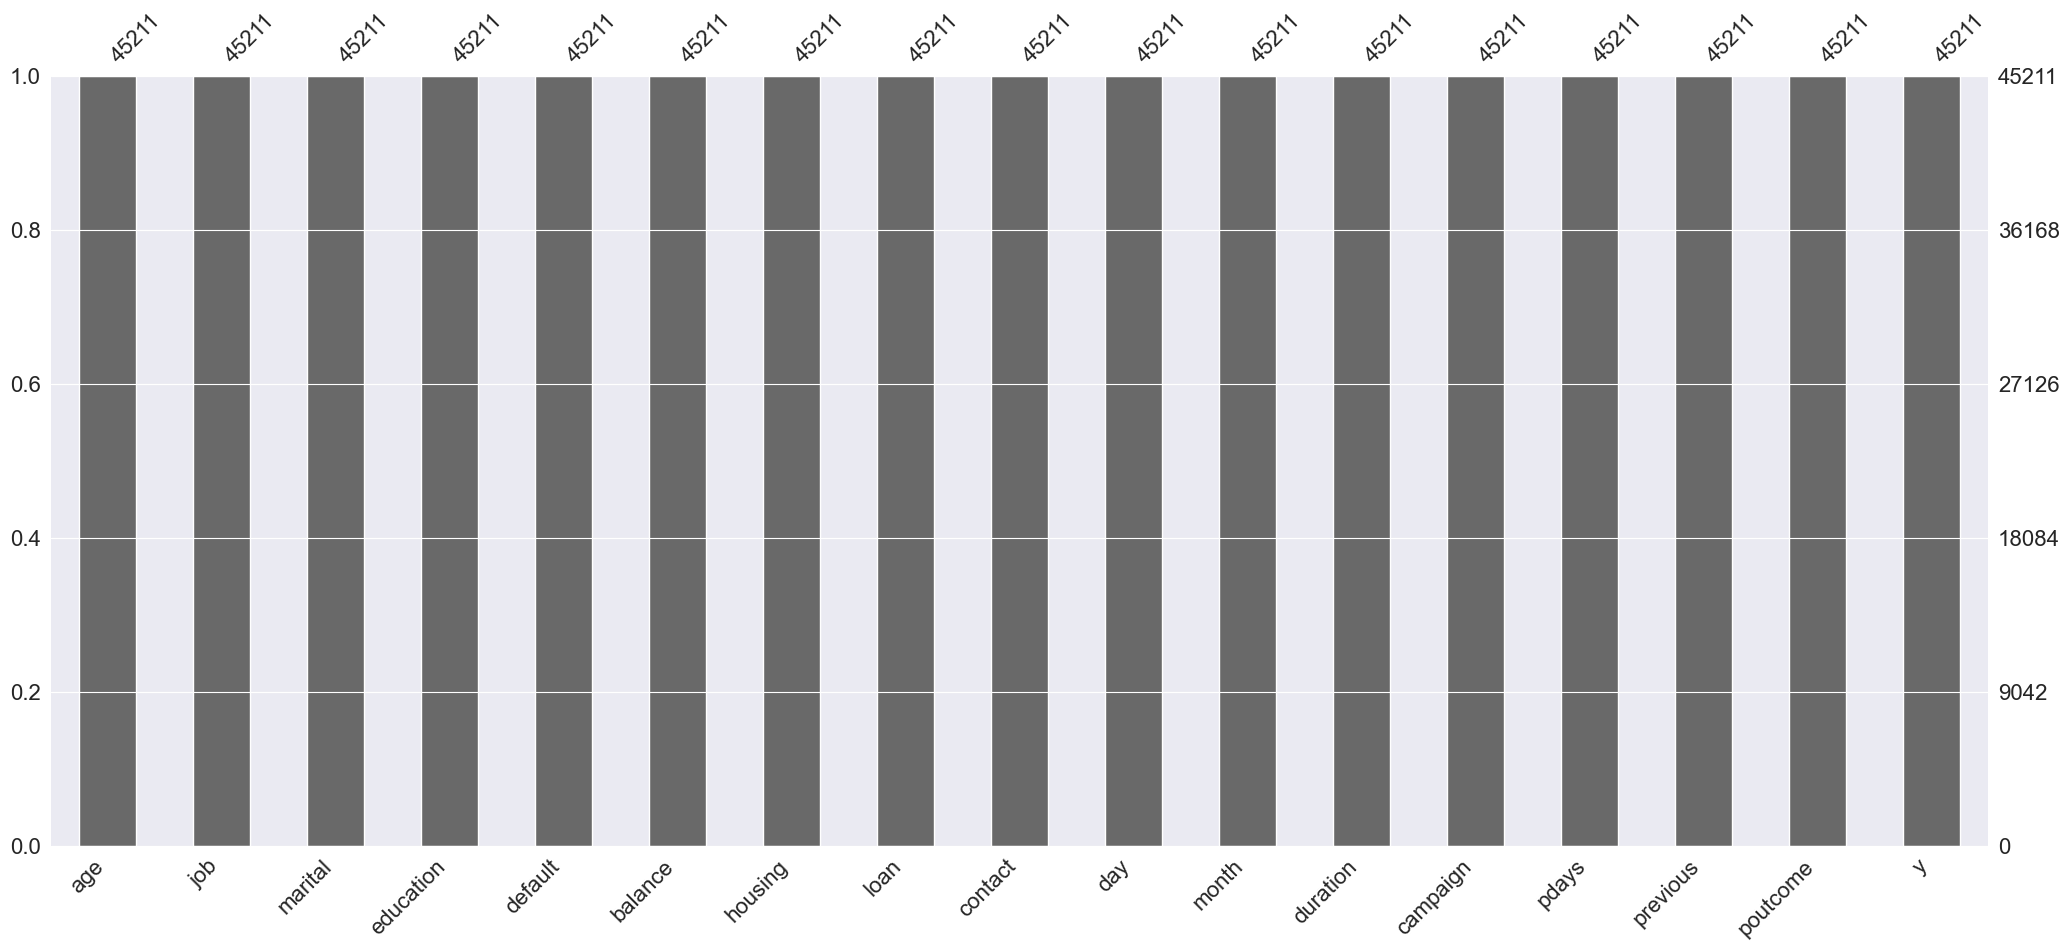

In [12]:
msno.bar(data)

In [13]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58.0,management,married,tertiary,no,2143.0,yes,no,cellular,5.0,may,261.0,1.0,-1.0,0.0,failure,no
1,44.0,technician,single,secondary,no,29.0,yes,no,cellular,5.0,may,151.0,1.0,-1.0,0.0,failure,no
2,33.0,entrepreneur,married,secondary,no,2.0,yes,yes,cellular,5.0,may,76.0,1.0,-1.0,0.0,failure,no
3,47.0,blue-collar,married,secondary,no,1506.0,yes,no,cellular,5.0,may,92.0,1.0,-1.0,0.0,failure,no
4,33.0,blue-collar,single,secondary,no,1.0,no,no,cellular,5.0,may,198.0,1.0,-1.0,0.0,failure,no


In [14]:

dataNum=data.select_dtypes(include=np.number)

for i in dataNum.columns:
    fitted_box_normdataA, fitted_box_normlambdaA = st.yeojohnson(dataNum[i])
    dataNum[i]=fitted_box_normdataA
    norm=MinMaxScaler((0,1)).fit(dataNum[[i]])
    dataNum[i]=norm.transform(dataNum[[i]])

In [15]:
data2=pd.concat([dataNum,data[["loan","job"]]],axis=1)
data3=data2.copy()

In [16]:
y=data2["loan"]
X=data2.drop("loan",axis=1)


In [17]:
y.value_counts()

loan
no     37967
yes     7244
Name: count, dtype: int64

Ordinal Encode-Job

In [18]:
enc = OrdinalEncoder(categories=[["no","yes"],data2["job"].unique().tolist()])
enc.fit(data2.select_dtypes(include=np.object_))
data2[data2.select_dtypes(include=np.object_).columns] = enc.transform(data2.select_dtypes(include=np.object_))

y=data2["loan"]
X=data2.drop("loan",axis=1)
undersample = NearMiss(version=3, n_neighbors_ver3=3)
X, y = undersample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

In [19]:
kf = KFold(n_splits=5)
params = {
    "kernel" : ["linear", "rbf", "poly"],
    "gamma" : [0.01],
    "C": [0.01],
    "degree" :[0],
    "random_state" :[0]
}

grid_rf = GridSearchCV(SVC(),refit = True, verbose=2, param_grid=params, cv=kf, 
                          scoring='accuracy').fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   2.0s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   2.3s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.7s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.7s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.7s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.1s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.2s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.2s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.1s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.1s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=poly, random_state=

In [20]:




y_predTest = grid_rf.predict(X_test)

grid_rf_Recall = recall_score(y_test, y_predTest)
grid_rf_Precision = precision_score(y_test, y_predTest)
grid_rf_f1 = f1_score(y_test, y_predTest)
grid_rf_accuracy = accuracy_score(y_test, y_predTest)





ndf2 = [(grid_rf_Recall, grid_rf_Precision, grid_rf_f1, grid_rf_accuracy)]

grid_score = pd.DataFrame(data = ndf2, columns=
                        ['Recall','Precision','F1 Score', 'Accuracy'],index=["Ordinal Encoding for Job [Test Metrics]"])



grid_score

,Recall,Precision,F1 Score,Accuracy
Ordinal Encoding for Job [Test Metrics],0.590752,0.650456,0.619168,0.636646


OneHot Encode-Job

In [21]:

custom_fnames_enc = OneHotEncoder(feature_name_combiner=custom_combiner).fit(data3.select_dtypes(include=np.object_))
data3[custom_fnames_enc.get_feature_names_out()]=custom_fnames_enc.transform(data3.select_dtypes(include=np.object_)).toarray()
data3=data3.drop("job",axis=1)
data3=data3.drop("loan",axis=1)
data3=data3.drop("loan_str_no",axis=1)


In [22]:
y=data3["loan_str_yes"]
X=data3.drop("loan_str_yes",axis=1)
undersample = NearMiss(version=3, n_neighbors_ver3=3)
X, y = undersample.fit_resample(X, y)

In [23]:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

In [24]:
kf = KFold(n_splits=5)
params = {
    "kernel" : ["linear", "rbf", "poly"],
    "gamma" : [0.01],
    "C": [0.01],
    "degree" :[0],
    "random_state" :[0]
}

grid_rf = GridSearchCV(SVC(),refit = True, verbose=2, param_grid=params, cv=kf, 
                          scoring='accuracy').fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.7s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.6s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.5s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.5s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.5s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.5s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.4s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.5s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.5s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.5s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=poly, random_state=

C:\Users\ASUS\PycharmProjects\pythonProject5\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [25]:











y_predTest = grid_rf.predict(X_test)

grid_rf_Recall = recall_score(y_test, y_predTest)
grid_rf_Precision = precision_score(y_test, y_predTest)
grid_rf_f1 = f1_score(y_test, y_predTest)
grid_rf_accuracy = accuracy_score(y_test, y_predTest)



ndf2 = [(grid_rf_Recall, grid_rf_Precision, grid_rf_f1, grid_rf_accuracy)]

grid_score2 = pd.DataFrame(data = ndf2, columns=
                        ['Recall','Precision','F1 Score', 'Accuracy'],index=["Onehot Encoding for Job [Test Metrics]"])




grid_score2

,Recall,Precision,F1 Score,Accuracy
Onehot Encoding for Job [Test Metrics],0.626639,0.656069,0.641017,0.649068


Ordinal Encode-Education

In [26]:
data2=pd.concat([dataNum,data[["loan","education"]]],axis=1)
data3=data2.copy()

In [27]:
data2["education"].unique()

array(['tertiary', 'secondary', 'primary'], dtype=object)

In [28]:
enc = OrdinalEncoder(categories=[["no","yes"],["primary","secondary","tertiary"]])
enc.fit(data2.select_dtypes(include=np.object_))
data2[data2.select_dtypes(include=np.object_).columns] = enc.transform(data2.select_dtypes(include=np.object_))

y=data2["loan"]
X=data2.drop("loan",axis=1)
undersample = NearMiss(version=3, n_neighbors_ver3=3)
X, y = undersample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

In [29]:


kf = KFold(n_splits=5)
params = {
    "kernel" : ["linear", "rbf", "poly"],
    "gamma" : [0.01],
    "C": [0.01],
    "degree" :[0],
    "random_state" :[0]
}
grid_rf = GridSearchCV(SVC(),refit = True, verbose=2, param_grid=params, cv=kf, 
                          scoring='accuracy').fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.8s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.6s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.6s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.5s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.6s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.0s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.2s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.1s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.1s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.2s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=poly, random_state=

C:\Users\ASUS\PycharmProjects\pythonProject5\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [30]:


y_predTest = grid_rf.predict(X_test)

grid_rf_Recall = recall_score(y_test, y_predTest)
grid_rf_Precision = precision_score(y_test, y_predTest)
grid_rf_f1 = f1_score(y_test, y_predTest)
grid_rf_accuracy = accuracy_score(y_test, y_predTest)





ndf2 = [(grid_rf_Recall, grid_rf_Precision, grid_rf_f1, grid_rf_accuracy)]

grid_score3 = pd.DataFrame(data = ndf2, columns=
                        ['Recall','Precision','F1 Score', 'Accuracy'],index=["Ordinal Encoding for Education[Test Metrics]"])


grid_score3

,Recall,Precision,F1 Score,Accuracy
Ordinal Encoding for Education[Test Metrics],0.559696,0.684966,0.616027,0.651139


OneHot Encode-Education

In [31]:

custom_fnames_enc = OneHotEncoder(feature_name_combiner=custom_combiner).fit(data3.select_dtypes(include=np.object_))
data3[custom_fnames_enc.get_feature_names_out()]=custom_fnames_enc.transform(data3.select_dtypes(include=np.object_)).toarray()
data3=data3.drop("education",axis=1)
data3=data3.drop("loan",axis=1)
data3=data3.drop("loan_str_no",axis=1)


In [32]:

y=data3["loan_str_yes"]
X=data3.drop("loan_str_yes",axis=1)
undersample = NearMiss(version=3, n_neighbors_ver3=3)
X, y = undersample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

In [33]:
kf = KFold(n_splits=5)
params = {
    "kernel" : ["linear", "rbf", "poly"],
    "gamma" : [0.01],
    "C": [0.01],
    "degree" :[0],
    "random_state" :[0]
}

grid_rf = GridSearchCV(SVC(),refit = True, verbose=2, param_grid=params, cv=kf, 
                          scoring='accuracy').fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   2.0s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.5s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.7s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.5s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=linear, random_state=0; total time=   1.5s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.3s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.2s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.2s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.1s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=rbf, random_state=0; total time=   3.2s
[CV] END C=0.01, degree=0, gamma=0.01, kernel=poly, random_state=

In [34]:









y_predTest = grid_rf.predict(X_test)
y_predTrain= grid_rf.predict(X_train)

grid_rf_Recall = recall_score(y_test, y_predTest)
grid_rf_Precision = precision_score(y_test, y_predTest)
grid_rf_f1 = f1_score(y_test, y_predTest)
grid_rf_accuracy = accuracy_score(y_test, y_predTest)


grid_rf_RecallTrain = recall_score(y_train, y_predTrain)
grid_rf_PrecisionTrain = precision_score(y_train, y_predTrain)
grid_rf_f1Train = f1_score(y_train, y_predTrain)
grid_rf_accuracyTrain = accuracy_score(y_train, y_predTrain)


ndf2 = [(grid_rf_Recall, grid_rf_Precision, grid_rf_f1, grid_rf_accuracy)]

grid_score4 = pd.DataFrame(data = ndf2, columns=
                        ['Recall','Precision','F1 Score', 'Accuracy'],index=["Onehot Encoding for Education[Test Metrics]"])





grid_score4

,Recall,Precision,F1 Score,Accuracy
Onehot Encoding for Education[Test Metrics],0.585921,0.649083,0.615887,0.634576


Table

In [35]:
totaldfoneh=pd.concat([grid_score, grid_score2])
totaldford=pd.concat([grid_score3, grid_score4])

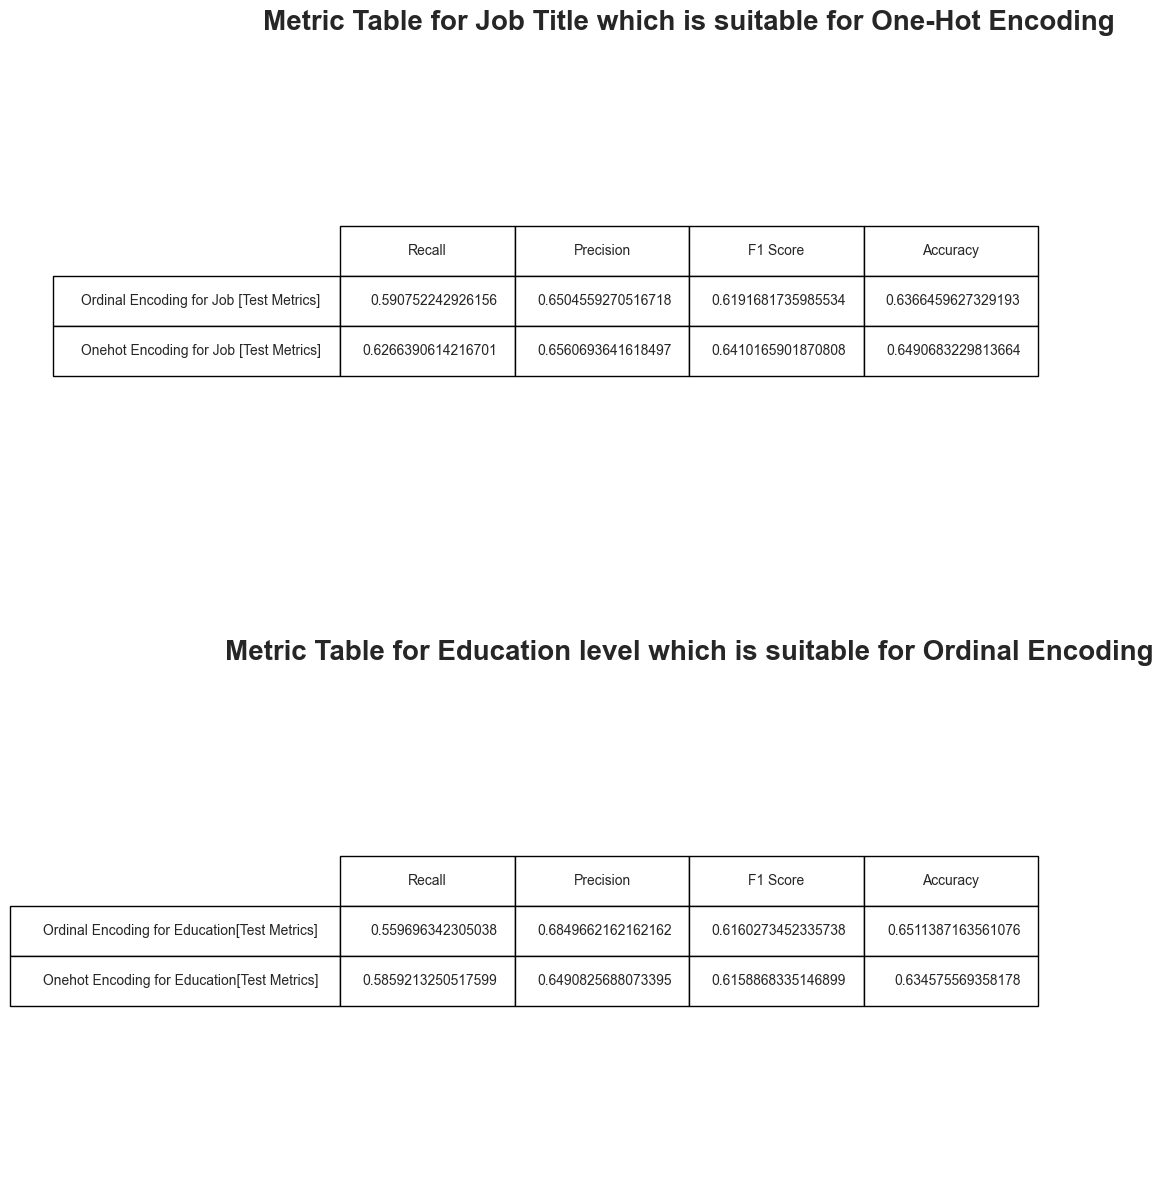

In [36]:

plt.rcParams["figure.figsize"] = (10,15)
fix, ax = plt.subplots(nrows=2, ncols=1)

ax[0].axis("off")
ax[0].axis('tight')
ax[0].set_title("Metric Table for Job Title which is suitable for One-Hot Encoding", weight='bold',fontsize=20)
ax[0].table(cellText=totaldfoneh.to_numpy(),rowLabels=totaldfoneh.index.tolist(),colLabels=totaldfoneh.columns.tolist(),loc='center').scale(0.9,3)



ax[1].axis("off")
ax[1].axis('tight')
ax[1].set_title("Metric Table for Education level which is suitable for Ordinal Encoding", weight='bold',fontsize=20)
ax[1].table(cellText=totaldford.to_numpy(),rowLabels=totaldford.index.tolist(),colLabels=totaldford.columns.tolist(),loc='center').scale(0.9,3)


